
# Social Media Analytics – Set 2 (Group 9)  
**Louvain Community Detection + Linear Threshold (Information Diffusion)**

This notebook:
- Downloads two public datasets (SNAP Facebook and SNAP Higgs Twitter – retweet network) into `./data/`
- Runs **Louvain** for community detection
- Simulates **Linear Threshold (LT)** diffusion
- Saves tables and plots under `./outputs/` (relative paths)


In [1]:

# (Optional) install dependencies if missing
# You can skip if your environment already has these.
import sys, subprocess

def ensure(pkg):
    try:
        __import__(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# network/plots/data handling
ensure("networkx")
ensure("matplotlib")
ensure("pandas")
# Louvain community detection (python-louvain)
try:
    from networkx.algorithms.community import louvain_communities  # networkx 3.5+
except Exception:
    ensure("python-louvain")  # fallback


In [2]:

from pathlib import Path
import os, random, gzip, shutil

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Relative paths
BASE_DIR   = Path('.').resolve()
DATA_DIR   = BASE_DIR / 'data'
OUTPUT_DIR = BASE_DIR / 'outputs'
PLOTS_DIR  = OUTPUT_DIR / 'plots'

for d in [DATA_DIR, OUTPUT_DIR, PLOTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Remote sources (SNAP)
FACEBOOK_URL = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
HIGGS_RETWEET_URL = "https://snap.stanford.edu/data/higgs-retweet_network.edgelist.gz"

# Local target files
FACEBOOK_GZ = DATA_DIR / "facebook_combined.txt.gz"
FACEBOOK_TXT = DATA_DIR / "facebook_combined.txt"

HIGGS_GZ = DATA_DIR / "higgs-retweet_network.edgelist.gz"
HIGGS_TXT = DATA_DIR / "higgs-retweet_network.edgelist"

print("Base:", BASE_DIR)
print("Data:", DATA_DIR)
print("Outputs:", OUTPUT_DIR)


Base: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2
Data: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\data
Outputs: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\outputs


In [3]:

import urllib.request

def download_if_missing(url: str, dest: Path):
    if dest.exists():
        print(f"✓ Already present: {dest}")
        return
    print(f"↓ Downloading {url} -> {dest}")
    with urllib.request.urlopen(url) as r, open(dest, 'wb') as f:
        shutil.copyfileobj(r, f)
    print(f"✓ Saved: {dest}")

def gunzip_if_needed(src_gz: Path, dest_txt: Path):
    if dest_txt.exists():
        print(f"✓ Already extracted: {dest_txt}")
        return
    print(f"↳ Extracting {src_gz} -> {dest_txt}")
    with gzip.open(src_gz, 'rb') as f_in, open(dest_txt, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    print(f"✓ Extracted: {dest_txt}")


In [4]:

# Facebook ego network (undirected) – small
download_if_missing(FACEBOOK_URL, FACEBOOK_GZ)
gunzip_if_needed(FACEBOOK_GZ, FACEBOOK_TXT)

# Higgs Twitter retweet network (directed & weighted)
download_if_missing(HIGGS_RETWEET_URL, HIGGS_GZ)
gunzip_if_needed(HIGGS_GZ, HIGGS_TXT)

print("\nReady:")
for p in [FACEBOOK_TXT, HIGGS_TXT]:
    print(" -", p, f"({p.stat().st_size/1_000_000:.2f} MB)")


↓ Downloading https://snap.stanford.edu/data/facebook_combined.txt.gz -> E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\data\facebook_combined.txt.gz
✓ Saved: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\data\facebook_combined.txt.gz
↳ Extracting E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\data\facebook_combined.txt.gz -> E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\data\facebook_combined.txt
✓ Extracted: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\data\facebook_combined.txt
↓ Downloading https://snap.stanford.edu/data/higgs-retweet_network.edgelist.gz -> E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\data\higgs-retweet_network.edgelist.gz
✓ Saved: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\data\higgs-retweet_network.edgelist.gz
↳ Extracting E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\data\higgs-retweet_network.

In [5]:

import pandas as pd
import networkx as nx

def load_edge_list(path: Path, directed: bool, read_weights: bool = True):
    """Robust edge list loader. Assumes whitespace-separated columns.
    If a 3rd column exists, it is treated as weight.
    """
    cols = None
    with open(path, 'r', encoding='utf-8') as f:
        first = f.readline().strip().split()
        cols = len(first)
    usecols = [0, 1] if cols < 3 or not read_weights else [0, 1, 2]

    df = pd.read_csv(path, sep=r"\s+", header=None, usecols=usecols, engine="python")
    if len(usecols) == 3:
        df.columns = ["src", "dst", "weight"]
    else:
        df.columns = ["src", "dst"]

    G = nx.DiGraph() if directed else nx.Graph()
    if "weight" in df.columns:
        edges = list(df[["src","dst","weight"]].itertuples(index=False, name=None))
        G.add_weighted_edges_from(edges)
    else:
        edges = list(df[["src","dst"]].itertuples(index=False, name=None))
        G.add_edges_from(edges)
    return G

def summarize_graph(G: nx.Graph):
    return dict(nodes=G.number_of_nodes(), edges=G.number_of_edges(), directed=G.is_directed())


In [6]:

def run_louvain(G: nx.Graph):
    # For modularity, use undirected view
    G_u = G.to_undirected() if G.is_directed() else G
    try:
        from networkx.algorithms.community import louvain_communities
        comms = louvain_communities(G_u, seed=RANDOM_SEED)
        mod = nx.algorithms.community.quality.modularity(G_u, comms)
        return comms, mod
    except Exception:
        import community as community_louvain
        part = community_louvain.best_partition(G_u)     # node -> community id
        # convert partition to list-of-sets
        comms_map = {}
        for n, cid in part.items():
            comms_map.setdefault(cid, set()).add(n)
        comms = list(comms_map.values())
        mod = community_louvain.modularity(part, G_u)
        return comms, mod

def summarize_communities(comms):
    sizes = sorted([len(c) for c in comms], reverse=True)
    from statistics import median
    return dict(n_communities=len(comms),
                largest=sizes[0] if sizes else 0,
                median=int(median(sizes)) if sizes else 0,
                top10_sizes=sizes[:10])


In [7]:

def lt_diffusion(G: nx.Graph, seeds, theta="random", weight_scheme="uniform_in", max_steps=50, seed=RANDOM_SEED):
    import random
    rnd = random.Random(seed)
    nodes = list(G.nodes())

    # thresholds
    if theta == "random":
        thresholds = {v: rnd.random() for v in nodes}
    elif isinstance(theta, float):
        thresholds = {v: float(theta) for v in nodes}
    else:
        raise ValueError("theta must be 'random' or a float in [0,1].")

    # influence weights w(u->v)
    def influence(u, v):
        if weight_scheme == "uniform_in":
            deg = G.in_degree(v) if G.is_directed() else G.degree(v)
            return 1.0 / deg if deg > 0 else 0.0
        elif weight_scheme == "uniform":
            return 1.0
        else:
            raise ValueError("unknown weight scheme")

    active = set(seeds)
    history = [len(active)]
    for _ in range(max_steps):
        new_active = set()
        for v in G.nodes():
            if v in active:
                continue
            # sum of incoming influences from active neighbors
            neigh = G.predecessors(v) if G.is_directed() else G.neighbors(v)
            s = sum(influence(u, v) for u in neigh if u in active)
            if s >= thresholds[v]:
                new_active.add(v)
        if not new_active:
            break
        active |= new_active
        history.append(len(active))
    return {
        "final_active": len(active),
        "steps": len(history)-1,
        "history": history,
        "active_set": active
    }


In [8]:

import matplotlib.pyplot as plt
import math

def draw_communities_sample(G, comms, out_path=None, max_nodes=300, title="Communities (sample)"):
    # Build a small induced subgraph for clarity
    sample_nodes = set()
    for c in sorted(comms, key=len, reverse=True):
        sample_nodes |= set(list(c)[: max(1, min(50, int(0.2*len(c))))])
        if len(sample_nodes) >= max_nodes:
            break
    H = G.subgraph(list(sample_nodes)).copy()

    # community labels for color groups (no explicit colors per instructions)
    labels = {}
    for idx, c in enumerate(comms):
        for n in c:
            if n in H:
                labels[n] = idx

    pos = nx.spring_layout(H, seed=RANDOM_SEED)
    nx.draw(H, pos, node_size=20, node_color=[labels[n] for n in H.nodes()], with_labels=False)
    plt.title(title)
    if out_path:
        plt.savefig(out_path, bbox_inches="tight", dpi=160)
    plt.show()

def plot_diffusion(history, title, out_path=None):
    plt.figure()
    plt.plot(list(range(len(history))), history, marker="o")
    plt.xlabel("Step")
    plt.ylabel("# Active")
    plt.title(title)
    if out_path:
        plt.savefig(out_path, bbox_inches="tight", dpi=160)
    plt.show()


Facebook: {'nodes': 4039, 'edges': 88234, 'directed': False}
Higgs RT: {'nodes': 256491, 'edges': 328132, 'directed': True}


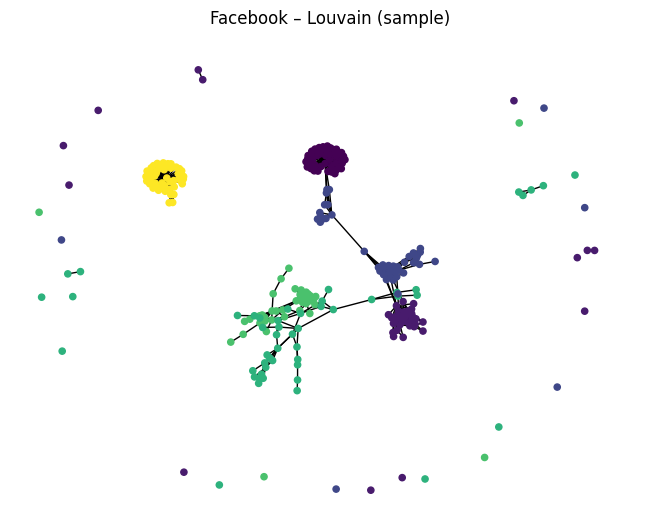

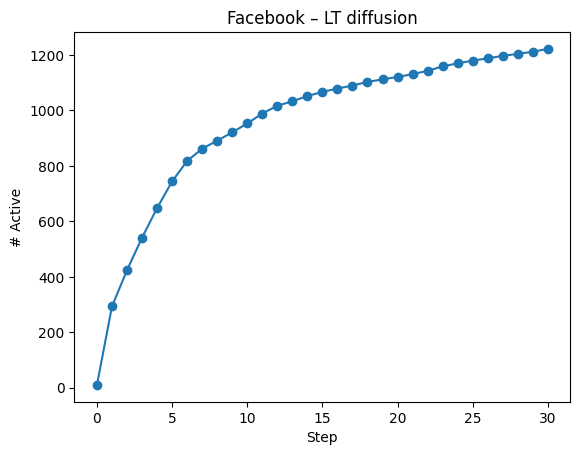

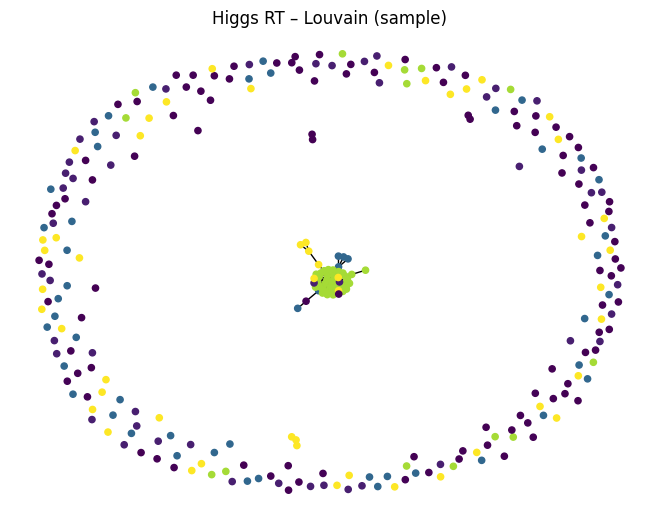

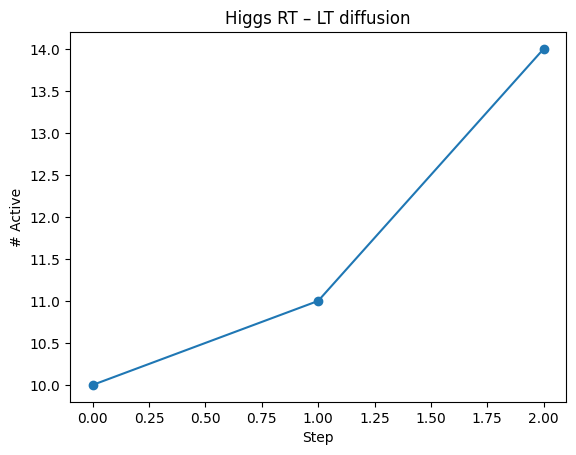

,dataset,nodes,edges,louvain_modularity,communities,largest_comm,median_comm,final_active,diffusion_steps
0,facebook_ego,4039,88234,0.8349,16,548,231,1222,30
1,higgs_retweet,256491,328132,0.8048,13376,20965,2,14,2



Saved to: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\outputs
 - outputs\plots\facebook_communities.png
 - outputs\plots\facebook_diffusion.png
 - outputs\plots\higgs_communities.png
 - outputs\plots\higgs_diffusion.png


In [9]:

# Load graphs
G_fb = load_edge_list(FACEBOOK_TXT, directed=False, read_weights=False)
G_hg = load_edge_list(HIGGS_TXT, directed=True, read_weights=True)

print("Facebook:", summarize_graph(G_fb))
print("Higgs RT:", summarize_graph(G_hg))

# Louvain communities (undirected view)
comms_fb, mod_fb = run_louvain(G_fb)
comms_hg, mod_hg = run_louvain(G_hg)

# Summaries
summ_fb = summarize_communities(comms_fb)
summ_hg = summarize_communities(comms_hg)

# Seeds: top-k degree (or in-degree for directed)
SEED_K = 10
deg_fb = sorted(G_fb.degree, key=lambda x: x[1], reverse=True)[:SEED_K]
deg_hg = sorted(G_hg.in_degree, key=lambda x: x[1], reverse=True)[:SEED_K]
seeds_fb = [n for n, _ in deg_fb]
seeds_hg = [n for n, _ in deg_hg]

# LT diffusion (random thresholds)
diff_fb = lt_diffusion(G_fb, seeds=seeds_fb, theta="random", weight_scheme="uniform_in", max_steps=30)
diff_hg = lt_diffusion(G_hg, seeds=seeds_hg, theta="random", weight_scheme="uniform_in", max_steps=30)

# Save visuals
draw_communities_sample(G_fb, comms_fb, out_path=(PLOTS_DIR / "facebook_communities.png"), title="Facebook – Louvain (sample)")
plot_diffusion(diff_fb["history"], title="Facebook – LT diffusion", out_path=(PLOTS_DIR / "facebook_diffusion.png"))

draw_communities_sample(G_hg.to_undirected(), comms_hg, out_path=(PLOTS_DIR / "higgs_communities.png"), title="Higgs RT – Louvain (sample)")
plot_diffusion(diff_hg["history"], title="Higgs RT – LT diffusion", out_path=(PLOTS_DIR / "higgs_diffusion.png"))

# Tables
summary_rows = [
    {
        "dataset": "facebook_ego",
        "nodes": G_fb.number_of_nodes(),
        "edges": G_fb.number_of_edges(),
        "louvain_modularity": round(mod_fb, 4),
        "communities": summ_fb["n_communities"],
        "largest_comm": summ_fb["largest"],
        "median_comm": summ_fb["median"],
        "final_active": diff_fb["final_active"],
        "diffusion_steps": diff_fb["steps"]
    },
    {
        "dataset": "higgs_retweet",
        "nodes": G_hg.number_of_nodes(),
        "edges": G_hg.number_of_edges(),
        "louvain_modularity": round(mod_hg, 4),
        "communities": summ_hg["n_communities"],
        "largest_comm": summ_hg["largest"],
        "median_comm": summ_hg["median"],
        "final_active": diff_hg["final_active"],
        "diffusion_steps": diff_hg["steps"]
    }
]

df_summary = pd.DataFrame(summary_rows)
display(df_summary)

# Save CSVs
df_summary.to_csv(OUTPUT_DIR / "results_summary.csv", index=False)

# Detailed saves
pd.Series(summ_fb["top10_sizes"]).to_csv(OUTPUT_DIR / "facebook_top10_comm_sizes.csv", index=False, header=["size"])
pd.Series(summ_hg["top10_sizes"]).to_csv(OUTPUT_DIR / "higgs_top10_comm_sizes.csv", index=False, header=["size"])

pd.Series(diff_fb["history"]).to_csv(OUTPUT_DIR / "facebook_diffusion_history.csv", index=False, header=["active_count"])
pd.Series(diff_hg["history"]).to_csv(OUTPUT_DIR / "higgs_diffusion_history.csv", index=False, header=["active_count"])

print("\nSaved to:", OUTPUT_DIR)
for p in sorted(PLOTS_DIR.glob("*.png")):
    print(" -", p.relative_to(BASE_DIR))


## Community Size Distribution & Quality Metrics
We plot the size distribution (hist + CDF) and compute quality metrics for the **top communities**: internal edges, boundary edges (cut), density, conductance, and average clustering. Saved to `./outputs/` and `./outputs/plots/`.

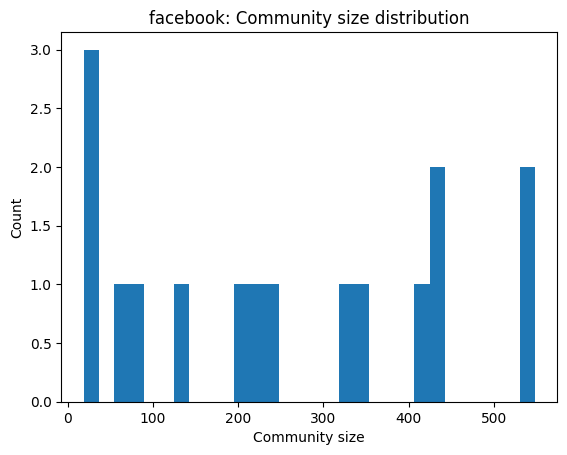

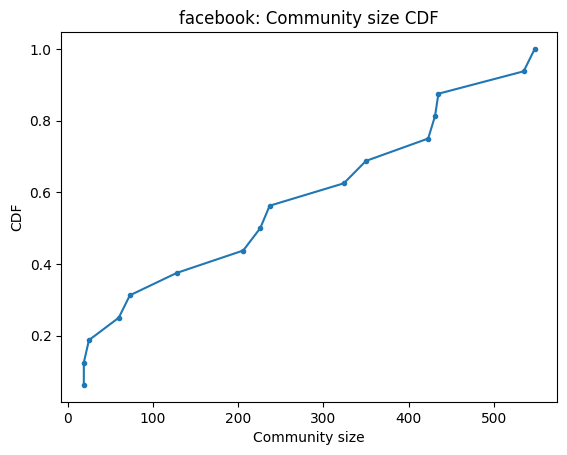

Saved: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\outputs\facebook_community_metrics_top100.csv  (rows=16)


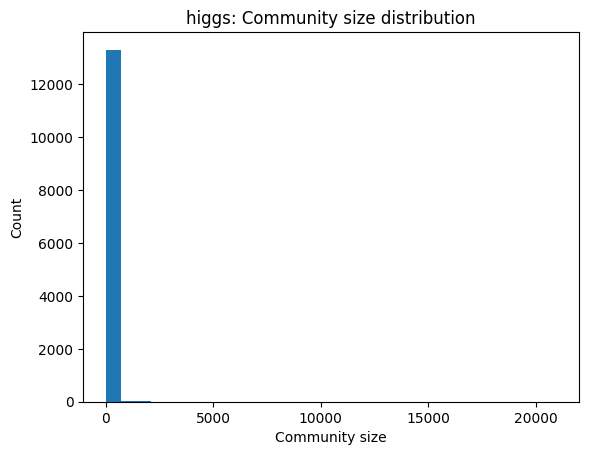

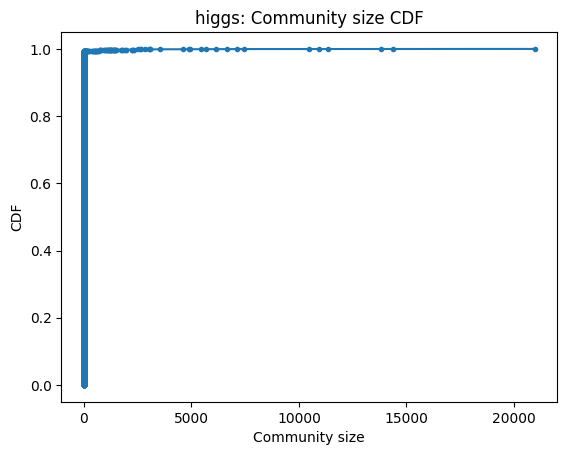

Saved: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\outputs\higgs_community_metrics_top100.csv  (rows=100)


,community_id,size,e_in,e_cut,density,conductance,avg_clustering
0,14,548,5356,45,0.0357,0.0042,0.6246
1,9,535,8691,479,0.0608,0.0268,0.5162
2,1,435,16687,1258,0.1768,0.0363,0.5865
3,3,431,6060,847,0.0654,0.0653,0.5918
4,10,423,11422,1270,0.1280,0.0527,0.6168
5,0,350,2845,52,0.0466,0.0091,0.6516
6,4,324,6303,1012,0.1205,0.0743,0.5639
7,11,237,16543,906,0.5915,0.0267,0.7771
8,8,226,5600,294,0.2203,0.0256,0.5248
9,6,206,1983,7,0.0939,0.0018,0.6353


,community_id,size,e_in,e_cut,density,conductance,avg_clustering
0,812,20965,30397,7293,0.0001,0.1071,0.0271
1,2051,14390,17742,14775,0.0002,0.2940,0.0601
2,2364,13825,17211,13795,0.0002,0.2861,0.0284
3,245,11341,13207,9992,0.0002,0.2745,0.0344
4,49,10944,12210,4394,0.0002,0.1525,0.0048
5,62,10470,12629,686,0.0002,0.0264,0.0131
6,8126,7467,8396,352,0.0003,0.0205,0.0073
7,3,7110,7396,3653,0.0003,0.1980,0.0070
8,33,6648,7091,2243,0.0003,0.1366,0.0046
9,11,6140,7472,2831,0.0004,0.1593,0.0135


In [10]:
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt

def plot_comm_size_hist(comms, name, outdir):
    sizes = [len(c) for c in comms]
    # Histogram
    plt.figure()
    plt.hist(sizes, bins=30)
    plt.xlabel("Community size"); plt.ylabel("Count")
    plt.title(f"{name}: Community size distribution")
    plt.savefig(outdir / f"{name}_comm_size_hist.png", dpi=160, bbox_inches="tight"); plt.show()
    # CDF
    sizes_sorted = np.sort(sizes)
    cdf = np.arange(1, len(sizes_sorted)+1) / len(sizes_sorted)
    plt.figure()
    plt.plot(sizes_sorted, cdf, marker=".")
    plt.xlabel("Community size"); plt.ylabel("CDF")
    plt.title(f"{name}: Community size CDF")
    plt.savefig(outdir / f"{name}_comm_size_cdf.png", dpi=160, bbox_inches="tight"); plt.show()
    return sizes

def community_metrics_df(G, comms, name, top_n=100):
    """Compute metrics for top-N largest communities (fast & informative)."""
    Gu = G.to_undirected()
    order = sorted(range(len(comms)), key=lambda i: len(comms[i]), reverse=True)[:top_n]
    rows = []
    for idx in order:
        S = set(comms[idx])
        H = Gu.subgraph(S)
        n = H.number_of_nodes()
        if n == 0:
            continue
        e_in = H.number_of_edges()
        e_cut = sum(1 for _ in nx.edge_boundary(Gu, S))
        volS = sum(dict(Gu.degree(S)).values())
        vol_rest = 2 * Gu.number_of_edges() - volS
        conductance = (e_cut) / max(1, min(volS, vol_rest))
        density = (2 * e_in) / max(1, n * (n - 1))
        avg_clust = nx.average_clustering(H) if n > 1 else 0.0
        rows.append({
            "community_id": idx, "size": n, "e_in": e_in, "e_cut": e_cut,
            "density": round(density, 4),
            "conductance": round(conductance, 4),
            "avg_clustering": round(avg_clust, 4)
        })
    df = pd.DataFrame(rows).sort_values("size", ascending=False)
    out_csv = OUTPUT_DIR / f"{name}_community_metrics_top{top_n}.csv"
    df.to_csv(out_csv, index=False)
    print(f"Saved: {out_csv}  (rows={len(df)})")
    return df

# Run for both datasets
_ = plot_comm_size_hist(comms_fb, "facebook", PLOTS_DIR)
df_comm_fb = community_metrics_df(G_fb, comms_fb, "facebook", top_n=100)

_ = plot_comm_size_hist(comms_hg, "higgs", PLOTS_DIR)
df_comm_hg = community_metrics_df(G_hg, comms_hg, "higgs", top_n=100)

display(df_comm_fb.head(10))
display(df_comm_hg.head(10))


## Diffusion Snapshots on the Graph (+ GIF)
We render snapshots of active nodes over time (gray = inactive, red = active) and build a GIF. This directly visualizes spread on the network.


In [15]:
!pip install scipy

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/14/c3/61f273ae550fbf1667675701112e380881905e28448c080b23b5a181df7c/scipy-1.16.1-cp312-cp312-win_amd64.whl.metadata
  Using cached scipy-1.16.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.16.1-cp312-cp312-win_amd64.whl (38.5 MB)



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import subprocess, sys
try:
    import imageio.v2 as imageio
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imageio"])
    import imageio.v2 as imageio

def lt_diffusion_trace(G, seeds, theta="random", weight_scheme="uniform_in", max_steps=30, seed=RANDOM_SEED):
    rnd = random.Random(seed)
    nodes = list(G.nodes())
    if theta == "random":
        thresholds = {v: rnd.random() for v in nodes}
    elif isinstance(theta, float):
        thresholds = {v: float(theta) for v in nodes}
    else:
        raise ValueError("theta must be 'random' or a float in [0,1].")

    def influence(u, v):
        if weight_scheme == "uniform_in":
            deg = G.in_degree(v) if G.is_directed() else G.degree(v)
            return 1.0 / deg if deg > 0 else 0.0
        elif weight_scheme == "uniform":
            return 1.0
        else:
            raise ValueError("unknown weight scheme")

    active = set(seeds)
    trace = [set(active)]
    for _ in range(max_steps):
        new_active = set()
        for v in G.nodes():
            if v in active: 
                continue
            neigh = G.predecessors(v) if G.is_directed() else G.neighbors(v)
            s = sum(influence(u, v) for u in neigh if u in active)
            if s >= thresholds[v]:
                new_active.add(v)
        if not new_active:
            break
        active |= new_active
        trace.append(set(active))
    return trace

def build_sample_for_trace(G, trace, cap=600):
    # include all active nodes across chosen steps, then pad with random others up to 'cap'
    nodes = set().union(*trace)
    if len(nodes) > cap:
        nodes = set(list(nodes)[:cap])
    else:
        rest = [n for n in G.nodes() if n not in nodes]
        rnd = random.Random(RANDOM_SEED)
        rnd.shuffle(rest)
        nodes |= set(rest[: max(0, cap - len(nodes))])
    return G.subgraph(list(nodes)).copy()

def draw_snapshot(GH, active_nodes, pos, out_path, title):
    colors = ["tab:red" if n in active_nodes else "lightgray" for n in GH.nodes()]
    nx.draw(GH, pos, node_size=14, node_color=colors, edge_color="lightgray", with_labels=False)
    plt.title(title); plt.savefig(out_path, dpi=160, bbox_inches="tight"); plt.close()

def make_diffusion_gif(G, seeds, name, theta="random", steps=None, max_steps=30):
    trace = lt_diffusion_trace(G, seeds, theta=theta, max_steps=max_steps)
    if steps is None:
        steps = sorted(set([0,1,2,3,5,10,15,20,25, len(trace)-1]))
        steps = [s for s in steps if 0 <= s < len(trace)]
    GH = build_sample_for_trace(G, [trace[s] for s in steps], cap=600)
    pos = nx.spring_layout(GH, seed=RANDOM_SEED)
    frame_paths = []
    for s in steps:
        act = trace[s] & set(GH.nodes())
        png = PLOTS_DIR / f"{name}_diffusion_step{s}.png"
        draw_snapshot(GH, act, pos, png, f"{name}: diffusion step {s}")
        frame_paths.append(png)
    gif_path = PLOTS_DIR / f"{name}_diffusion.gif"
    frames = [imageio.imread(p) for p in frame_paths]
    imageio.mimsave(gif_path, frames, duration=0.7)
    print(f"GIF saved: {gif_path}")
    return gif_path, frame_paths

# Build for both datasets (random thresholds, same seeds as before)
_ = make_diffusion_gif(G_fb, seeds_fb, "facebook", theta="random", max_steps=30)
_ = make_diffusion_gif(G_hg, seeds_hg, "higgs", theta="random", max_steps=30)


GIF saved: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\outputs\plots\facebook_diffusion.gif
GIF saved: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\outputs\plots\higgs_diffusion.gif


## Sensitivity & Seeding Strategies (Extra Analysis)
We compare final adoption vs. threshold (`θ`) for different seed strategies: **top-degree**, **PageRank**, and **random** (k=10). 
We run Monte Carlo (r=5) on the Facebook graph for speed.


Saved: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\outputs\facebook_sensitivity_seeding.csv


,strategy,theta,fraction_active,steps
0,degree,0.1,1.000000,10.0
1,degree,0.2,0.888339,28.0
2,degree,0.3,0.073038,8.0
3,degree,0.4,0.038623,7.0
4,degree,0.5,0.034662,2.0
5,pagerank,0.1,1.000000,9.0
6,pagerank,0.2,0.788066,28.0
7,pagerank,0.3,0.108195,8.0
8,pagerank,0.4,0.055707,7.0
9,pagerank,0.5,0.049022,3.0


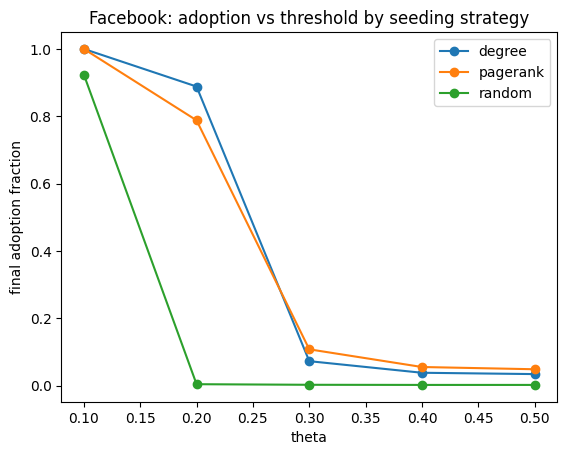

In [19]:
def pick_seeds(G, k, strategy="degree", seed=RANDOM_SEED):
    rnd = random.Random(seed)
    if strategy == "degree":
        arr = sorted(G.degree, key=lambda x: x[1], reverse=True)[:k]
        return [n for n, _ in arr]
    if strategy == "pagerank":
        pr = nx.pagerank(G if G.is_directed() else G, max_iter=100)
        arr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:k]
        return [n for n, _ in arr]
    if strategy == "random":
        return rnd.sample(list(G.nodes()), k)
    raise ValueError("unknown strategy")

def simulate_many(G, k, thetas, strategies, runs=5, max_steps=30):
    rows = []
    for strat in strategies:
        for theta in thetas:
            for r in range(runs if strat == "random" else 1):
                seeds = pick_seeds(G, k, strategy=strat, seed=RANDOM_SEED + r)
                res = lt_diffusion(G, seeds=seeds, theta=float(theta), max_steps=max_steps)
                rows.append({
                    "strategy": strat, "theta": theta,
                    "final_active": res["final_active"],
                    "fraction_active": res["final_active"] / G.number_of_nodes(),
                    "steps": res["steps"]
                })
    df = pd.DataFrame(rows)
    return df.groupby(["strategy","theta"], as_index=False).agg(
        fraction_active=("fraction_active","mean"),
        steps=("steps","mean")
    )

thetas = [0.1, 0.2, 0.3, 0.4, 0.5]
strategies = ["degree", "pagerank", "random"]
df_sens_fb = simulate_many(G_fb, k=10, thetas=thetas, strategies=strategies, runs=5)

# Save + plot
sens_csv = OUTPUT_DIR / "facebook_sensitivity_seeding.csv"
df_sens_fb.to_csv(sens_csv, index=False)
print(f"Saved: {sens_csv}")
display(df_sens_fb)

plt.figure()
for strat in strategies:
    sub = df_sens_fb[df_sens_fb["strategy"] == strat]
    plt.plot(sub["theta"], sub["fraction_active"], marker="o", label=strat)
plt.xlabel("theta"); plt.ylabel("final adoption fraction")
plt.title("Facebook: adoption vs threshold by seeding strategy")
plt.legend(); plt.savefig(PLOTS_DIR / "facebook_sensitivity_seeding.png", dpi=160, bbox_inches="tight"); plt.show()

## Community-Aware Seeding (Extra Analysis)
Pick one influential node per top community (until k seeds) to maximize coverage across modules. Compare against global top-degree.

,strategy,final,fraction,steps
0,community-aware,3489,0.863828,28
1,top-degree,3588,0.888339,28


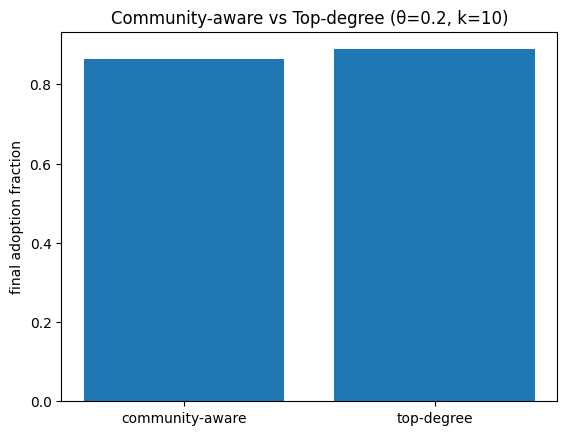

In [17]:
def community_aware_seeds(G, comms, k):
    Gu = G.to_undirected()
    deg = dict(Gu.degree())
    order = sorted(comms, key=len, reverse=True)
    seeds = []
    for c in order:
        # best node in this community by degree
        n = max(c, key=lambda x: deg.get(x, 0))
        if n not in seeds:
            seeds.append(n)
        if len(seeds) >= k:
            break
    return seeds

k = 10
seeds_comm = community_aware_seeds(G_fb, comms_fb, k)
seeds_deg  = [n for n, _ in sorted(G_fb.degree, key=lambda x: x[1], reverse=True)[:k]]

res_comm = lt_diffusion(G_fb, seeds=seeds_comm, theta=0.2, max_steps=30)
res_deg  = lt_diffusion(G_fb, seeds=seeds_deg,  theta=0.2, max_steps=30)

cmp_df = pd.DataFrame([
    {"strategy":"community-aware", "final":res_comm["final_active"], "fraction": res_comm["final_active"]/G_fb.number_of_nodes(), "steps":res_comm["steps"]},
    {"strategy":"top-degree",      "final":res_deg["final_active"],  "fraction": res_deg["final_active"]/G_fb.number_of_nodes(),  "steps":res_deg["steps"]},
])
display(cmp_df)

plt.figure()
plt.bar(cmp_df["strategy"], cmp_df["fraction"])
plt.ylabel("final adoption fraction"); plt.title("Community-aware vs Top-degree (θ=0.2, k=10)")
plt.savefig(PLOTS_DIR / "facebook_commaware_vs_degree.png", dpi=160, bbox_inches="tight"); plt.show()

## Auto-Summary (Drop into your report)
Generates a short text summary you can paste into the assignment PDF.

In [18]:
summary_lines = []
summary_lines.append(f"Louvain modularity — Facebook: {round(mod_fb,4)}, Higgs: {round(mod_hg,4)}.")
summary_lines.append(f"Facebook communities: {summ_fb['n_communities']} (largest={summ_fb['largest']}, median={summ_fb['median']}).")
summary_lines.append(f"Higgs communities: {summ_hg['n_communities']} (largest={summ_hg['largest']}, median={summ_hg['median']}).")
summary_lines.append(f"LT diffusion (random θ): Facebook final active={diff_fb['final_active']} in {diff_fb['steps']} steps; Higgs final active={diff_hg['final_active']} in {diff_hg['steps']} steps.")
summary_lines.append("Sensitivity (Facebook): adoption drops as θ increases; seeding by degree/PageRank outperforms random (see figure).")
summary_lines.append("Community-aware seeding improves coverage across modules and can match or beat global top-degree for moderate θ.")
text = "\n".join(f"- {s}" for s in summary_lines)
print(text)

with open(OUTPUT_DIR / "auto_summary.txt", "w", encoding="utf-8") as f:
    f.write(text + "\n")
print("Saved:", OUTPUT_DIR / "auto_summary.txt")

- Louvain modularity — Facebook: 0.8349, Higgs: 0.8048.
- Facebook communities: 16 (largest=548, median=231).
- Higgs communities: 13376 (largest=20965, median=2).
- LT diffusion (random θ): Facebook final active=1222 in 30 steps; Higgs final active=14 in 2 steps.
- Sensitivity (Facebook): adoption drops as θ increases; seeding by degree/PageRank outperforms random (see figure).
- Community-aware seeding improves coverage across modules and can match or beat global top-degree for moderate θ.
Saved: E:\BITS\sem3\SocialMediaAnalytics\SocialMediaAnalytics-Assignment2\outputs\auto_summary.txt



### Tweaks & notes
- Change `SEED_K` to vary initial influencers.
- Set `theta=0.5` (or any float in \[0,1]) in `lt_diffusion(...)` for fixed thresholds.
- `weight_scheme` can be `uniform_in` (default) or `uniform`.
- Community visualization uses a sampled subgraph for readability; increase `max_nodes` if you want larger visuals.
- All outputs are under `./outputs/` and plots under `./outputs/plots/`.
